In [44]:

import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from tensorflow import keras

from functions.image import get_filtered_satellite_float32, get_satellite_raw_uint8, remove_noise_satellite

In [45]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

In [46]:
dataset = rasterio.open("./data/crs.tiff")
img_data = dataset.read(1)
block_size = 30


def get_processed_image(coord):
    return get_filtered_satellite_float32(coord, block_size, img_data, dataset)


def get_raw_image(coord):
    return get_satellite_raw_uint8(coord, block_size, img_data, dataset)

In [47]:
import glob

examples = glob.glob("./examples/*/*.png", recursive=True)

In [48]:
import imageio

X1 = []
Y1 = []
for path in examples:
    category = path.split("/")[2]
    img = imageio.imread(path)
    if category == "boats" or category == "windmills":
        for i in range(4):
            if category == "boats":
                Y1.append(0)
            else:
                Y1.append(1)
            cp = np.expand_dims(remove_noise_satellite(img.copy()) / 255.0, -1)
            X1.append(cp)
            img = np.rot90(img)
    else:
        Y1.append(0)
        img = np.expand_dims(remove_noise_satellite(img) / 255.0, -1)
        X1.append(img)


In [49]:
X2 = []
Y2 = []
for path in examples:
    category = path.split("/")[2]
    img = imageio.imread(path)
    if category == "land" or category == "beach":
        Y2.append(1)
        img = np.expand_dims(img / 255.0, -1)
        X2.append(img)
    else:
        for i in range(4):
            Y2.append(0)
            cp = np.expand_dims(img.copy() / 255.0, -1)
            X2.append(cp)
            img = np.rot90(img)


In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1, test_size=0.3)

X_train = np.stack(X_train)
X_test = np.stack(X_test)
Y_train = keras.utils.to_categorical(Y_train, 2)
Y_test = keras.utils.to_categorical(Y_test, 2)

In [51]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

windmill_model = Sequential()

windmill_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
windmill_model.add(MaxPooling2D(pool_size=(2, 2)))
windmill_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
windmill_model.add(MaxPooling2D(pool_size=(2, 2)))
windmill_model.add(Flatten())
windmill_model.add(Dropout(0.5))
windmill_model.add(Dense(2, activation='sigmoid'))

windmill_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
windmill_model.fit(X_train, Y_train, epochs=10)

Epoch 1/10
76/76 [==============================] - 1s 11ms/step - loss: 0.6136 - accuracy: 0.6816

In [53]:
windmill_model.evaluate(X_test, Y_test, verbose=2)


33/33 - 0s - loss: 0.3667 - accuracy: 0.8602 - 189ms/epoch - 6ms/step


[0.36669182777404785, 0.8601941466331482]

In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X2, Y2, test_size=0.3)

X_train = np.stack(X_train)
X_test = np.stack(X_test)
Y_train = keras.utils.to_categorical(Y_train, 2)
Y_test = keras.utils.to_categorical(Y_test, 2)

In [55]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

land_model = Sequential()

land_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
land_model.add(MaxPooling2D(pool_size=(2, 2)))
land_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
land_model.add(MaxPooling2D(pool_size=(2, 2)))
land_model.add(Flatten())
land_model.add(Dropout(0.5))
land_model.add(Dense(2, activation='sigmoid'))

land_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
land_model.fit(X_train, Y_train, epochs=10)

Epoch 1/10
76/76 [==============================] - 1s 12ms/step - loss: 0.5313 - accuracy: 0.7828

In [57]:
land_model.evaluate(X_test, Y_test, verbose=2)

33/33 - 0s - loss: 0.2346 - accuracy: 0.8893 - 180ms/epoch - 5ms/step


[0.234589084982872, 0.8893203735351562]

found 172 windmills


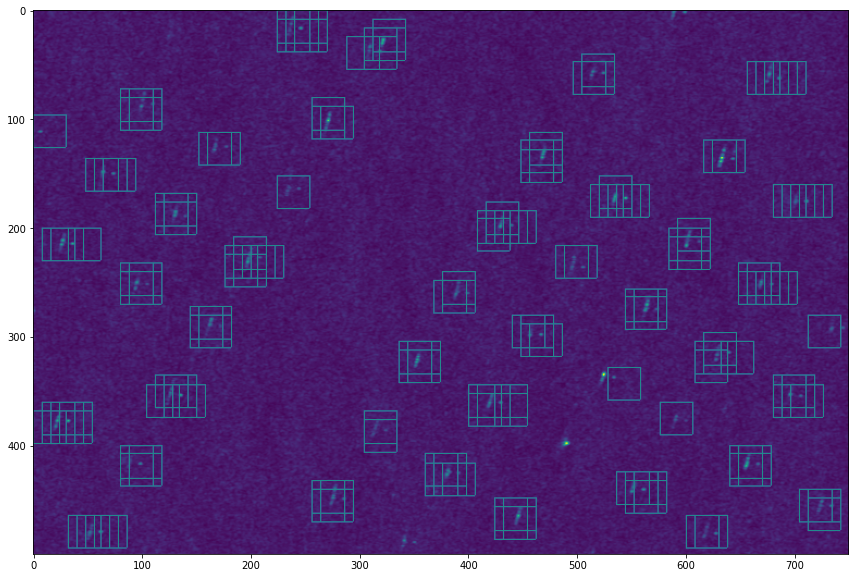

In [62]:
left_top_coord = (1.87565,51.96971)  # enter coordinate here
img_h, img_w = (750, 500)
left_top_x, left_top_y = dataset.index(left_top_coord[0], left_top_coord[1])
needles = []
step_size = 8

for xx in range(left_top_x + block_size // 2, left_top_x + img_w - block_size // 2, step_size):
    for yy in range(left_top_y + block_size // 2, left_top_y + img_h - block_size // 2, step_size):
        cc = dataset.transform * (yy, xx)
        needles.append({'lon': cc[0], 'lat': cc[1]})

land_test_data = np.stack(
    [np.expand_dims(get_satellite_raw_uint8(coord, block_size, img_data, dataset) / 255.0, -1) for coord in needles])
windmill_test_data = np.stack([get_processed_image(coord) for coord in needles])
result_wind = windmill_model.predict(windmill_test_data)
result_land = land_model.predict(land_test_data)

from matplotlib import pyplot as plt

search_space = np.copy(img_data[left_top_x:left_top_x + img_w, left_top_y:left_top_y + img_h])
highlight = np.max(search_space) / 2

found = 0
for i, result in enumerate(result_wind):
    is_land = result_land[i]
    if is_land[1] < is_land[0] and result[1] > result[0]:
        found += 1
        coord = needles[i]
        xx, yy = dataset.index(coord['lon'], coord['lat'])
        xx -= left_top_x
        yy -= left_top_y

        search_space[xx - block_size // 2:xx + block_size // 2, yy - block_size // 2] = highlight
        search_space[xx - block_size // 2:xx + block_size // 2, yy + block_size // 2] = highlight
        search_space[xx - block_size // 2, yy - block_size // 2:yy + block_size // 2] = highlight
        search_space[xx + block_size // 2, yy - block_size // 2:yy + block_size // 2] = highlight

print("found {} windmills".format(found))

plt.rcParams['figure.figsize'] = [20, 10]
plt.imshow(search_space)

In [135]:
from PIL import Image

j = 0

for i, result in enumerate(results):
    if result[1] < result[0]:
        continue
    coord = needles[i]
    a = get_satellite_raw_uint8(coord, block_size, img_data, dataset)
    im = Image.fromarray(a)
    im.save("./examples/%s-%s.png" % (str(coord["lon"]).replace(".", "_"), str(coord["lat"]).replace(".", "_")))
    if j > 200:
        break
    j += 1